In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

Notebook to compare auto diff libraries to quickly integrate ODEs and compute gradients

In [2]:
# method 1, JAX 
import jax 
import jax.numpy as jnp
from jax.experimental.ode import odeint

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# dimension of problem 
dim = 30

# define linear differential equation
def system(x, t, params):
    A = jnp.reshape(params, [dim, dim])
    return A@x

# make a stable system (eigenvalues of A must be negative)
A = np.random.randn(dim, dim)
A = -(A@A.T)

# random initial conditions 
x0 = np.random.randn(dim)

# time horizon
t_eval = np.linspace(0, 10)

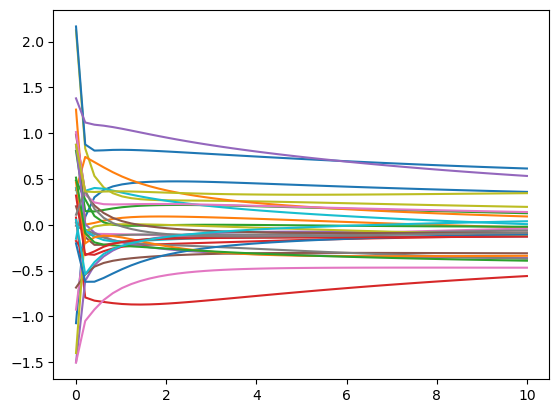

In [4]:
# solve ode 
y = odeint(system, x0, t_eval, A.flatten())
plt.plot(t_eval, y)
plt.show()

In [5]:
# define augmented system with forward sensitivity equations where
# dZ/dt = Jx@Z + Jp
Jx = jax.jit(jax.jacfwd(system, 0))
Jp = jax.jit(jax.jacfwd(system, 2))

def fwd_system(xZ, t, params):
    # unpack dependent variables
    x = xZ[:dim]
    Z = jnp.reshape(xZ[dim:], [dim, dim**2])
    
    # unpack parameters
    A = jnp.reshape(params, [dim, dim])
    
    dxdt = system(x, t, A)
    dZdt = Jx(x, t, params)@Z + Jp(x, t, params)
    
    return jnp.concatenate((dxdt, dZdt.flatten()))

In [6]:
%timeit Jp(x0, 0., A.flatten())

416 µs ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# solve ode 
xZ0 = jnp.concatenate((x0, jnp.zeros(dim*dim**2)))
jax_soln = odeint(fwd_system, xZ0, t_eval, A.flatten())

%timeit odeint(fwd_system, xZ0, t_eval, A.flatten())

1.77 s ± 97.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# method 2, PyTorch
import functorch
import torch
from torchdiffeq import odeint

In [9]:
# define linear differential equation
def system(x, t, params):
    A = torch.reshape(params, [dim, dim])
    return A@x

# make a stable system (eigenvalues of A must be negative)
A = torch.tensor(A, dtype=torch.float32)

# random initial conditions 
x0 = torch.tensor(x0, dtype=torch.float32)

# time horizon
t_eval = torch.tensor(t_eval, dtype=torch.float32)

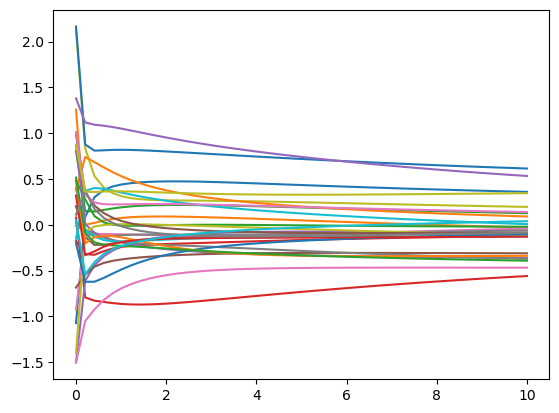

In [10]:
# solve ode 
torch_system = lambda t, x: system(x, t, A.flatten())
y = odeint(torch_system, x0, t_eval)
plt.plot(t_eval, y)
plt.show()

In [11]:
# define augmented system with forward sensitivity equations where
# dZ/dt = Jx@Z + Jp
Jx = torch.jit.trace(functorch.jacfwd(system, 0), (x0, t_eval[0], A.flatten()))
Jp = torch.jit.trace(functorch.jacfwd(system, 2), (x0, t_eval[0], A.flatten()))

def fwd_system(xZ, t, params):
    # unpack dependent variables
    x = xZ[:dim]
    Z = torch.reshape(xZ[dim:], [dim, dim**2])
    
    # unpack parameters
    A = torch.reshape(params, [dim, dim])
    
    dxdt = system(x, t, A)
    dZdt = Jx(x, t, params)@Z + Jp(x, t, params)
    
    return torch.concatenate((dxdt, dZdt.flatten()))

/home/jaron/anaconda3/lib/python3.9/site-packages/functorch/_src/eager_transforms.py:573: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  diag_start_indices = (0, *torch.tensor(tensor_numels).cumsum(dim=0)[:-1].neg().unbind())
/home/jaron/anaconda3/lib/python3.9/site-packages/functorch/_src/vmap.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if batch_sizes and any(size != batch_sizes[0] for size in batch_sizes):


In [12]:
%timeit Jp(x0, t_eval[0], A.flatten())

544 µs ± 174 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# solve ode 
xZ0 = torch.concatenate((x0, torch.zeros(dim*dim**2)))

def torch_fwd_system(t, x):
    return fwd_system(x, t, A.flatten())

%timeit odeint(torch_fwd_system, xZ0, t_eval)

3.04 s ± 967 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# try JIT compilation

torch_fwd_system_jit = torch.jit.trace(torch_fwd_system, (torch.tensor(0., dtype=torch.float32), xZ0))

torch_soln = odeint(torch_fwd_system_jit, xZ0, t_eval)
%timeit odeint(torch_fwd_system_jit, xZ0, t_eval)

2.42 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


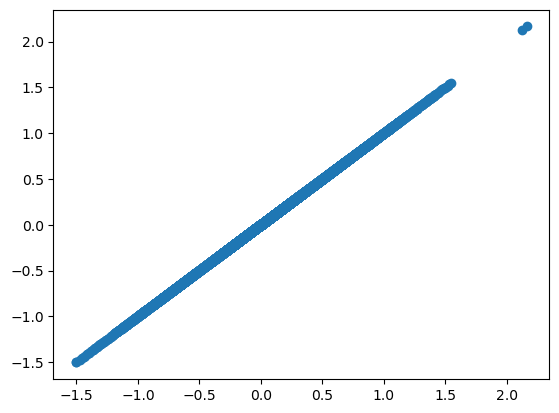

In [15]:
plt.scatter(torch_soln.numpy().flatten(), np.array(jax_soln).flatten())
plt.show()